# Chapter 10

## Building an Image Classifier Using the Sequential API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [2]:
root_dir = 'data'
full_train_dset = FashionMNIST(root=root_dir,
                               train=True,
                               download=True,
                               transform=ToTensor())
test_dset = FashionMNIST(root=root_dir,
                         train=False,
                         download=True,
                         transform=ToTensor())

In [3]:
device = 'cuda'
if torch.cuda.device_count() == 2:
    torch.cuda.set_device(1)

In [4]:
train_dset = Subset(full_train_dset, indices=range(55000))
valid_dset = Subset(full_train_dset, indices=range(55000, 60000))

In [5]:
len(train_dset), len(valid_dset)

(55000, 5000)

In [6]:
batch_size = 32 # Default batch size on keras

In [7]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Normalization

In Geron's book the data are normalized by dividing by 255. The `ToTensor()` transform added to the Dataset definition takes care of this automatically.

In [8]:
img, tgt = next(iter(valid_loader))

In [9]:
img.max()

tensor(1.)

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10))
    
    def forward(self, x):
        return self.sequential_model(x)

In [12]:
classif_model = MyModel()
classif_model

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [13]:
classif_model.sequential_model[1].bias[0]

tensor(-0.0237, grad_fn=<SelectBackward0>)

In [14]:
classif_model.sequential_model[1].weight[0, :10]

tensor([ 0.0046, -0.0107, -0.0128, -0.0025,  0.0348, -0.0174,  0.0259, -0.0163,
         0.0243, -0.0059], grad_fn=<SliceBackward0>)

## Weight initialization

In Keras weights in a dense layer are, [by default](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), initialized with a Glorot Uniform initialization.

In Pytorch weights in a linear layer are, [by default](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) initialized with a uniform distribution with  U(−k,k) where k=1/in_features. This is essentially a LeCun uniform initialization. Note that in PyTorch, Glorot initialization is called Xavier initialization.

In [15]:
@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

In [16]:
classif_model.apply(init_weights)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
classif_model.sequential_model[1].bias[0]

tensor(0., grad_fn=<SelectBackward0>)

In [18]:
classif_model.sequential_model[1].weight[0, :10]

tensor([-0.0482,  0.0128,  0.0131, -0.0169, -0.0428,  0.0225,  0.0709,  0.0432,
        -0.0656, -0.0359], grad_fn=<SliceBackward0>)

Both the bias and the weight look different. We assume that we are using the same initialization approach as Keras.

The Keras model has a final softmax activation. If we use PyTorch cross-entropy loss, the softmax is fused in the loss, so we don't need to include it.

In [19]:
classif_model.to(device)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()

## Optimizers

The example in Geron's book uses the "sgd" optimizer, which I suspect corresponds to the [default settings](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD), i.e., lr = 0.01 and momentum = 0.0.

In [21]:
classif_optim = optim.SGD(classif_model.parameters(), lr=0.01, momentum=0.0)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 250 == 0:
            print(f'Train loss: {batch_loss.item():>.5}')

In [23]:
def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    num_obs = len(dataloader.dataset)
    total_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()
    avg_batch_loss = total_loss / num_batches
    accuracy = correct / num_obs
    print('Validation:')
    print(f'\nAverage loss: {avg_batch_loss:>.5} - Accuracy: {accuracy:>.3}')
    return avg_batch_loss, accuracy

In [24]:
epochs = 30

In [25]:
test_loss, test_accuracy = [], []

for epoch in range(epochs):
    print(f'\n----- Epoch: {epoch+1} -----\n')
    train(train_loader, classif_model, loss_fn, classif_optim)
    loss, acc = validate(valid_loader, classif_model, loss_fn)
    test_loss.append(loss)
    test_accuracy.append(acc)


----- Epoch: 1 -----

Train loss: 2.3929
Train loss: 0.93195
Train loss: 0.54905
Train loss: 0.60388
Train loss: 0.77711
Train loss: 0.56643
Train loss: 0.43589
Validation:

Average loss: 0.54566 - Accuracy: 0.806

----- Epoch: 2 -----

Train loss: 0.50713
Train loss: 0.82873
Train loss: 0.56208
Train loss: 0.5899
Train loss: 0.3201
Train loss: 0.49011
Train loss: 0.341
Validation:

Average loss: 0.44484 - Accuracy: 0.84

----- Epoch: 3 -----

Train loss: 0.6944
Train loss: 0.22429
Train loss: 0.39264
Train loss: 0.5807
Train loss: 0.36953
Train loss: 0.42035
Train loss: 0.45779
Validation:

Average loss: 0.45213 - Accuracy: 0.838

----- Epoch: 4 -----

Train loss: 0.55071
Train loss: 0.34373
Train loss: 0.4501
Train loss: 0.38788
Train loss: 0.65659
Train loss: 0.46598
Train loss: 0.36876
Validation:

Average loss: 0.40774 - Accuracy: 0.852

----- Epoch: 5 -----

Train loss: 0.17387
Train loss: 0.26334
Train loss: 0.39497
Train loss: 0.30913
Train loss: 0.37235
Train loss: 0.2081
Tra

This is very similar to the performance shown in Geron's book.

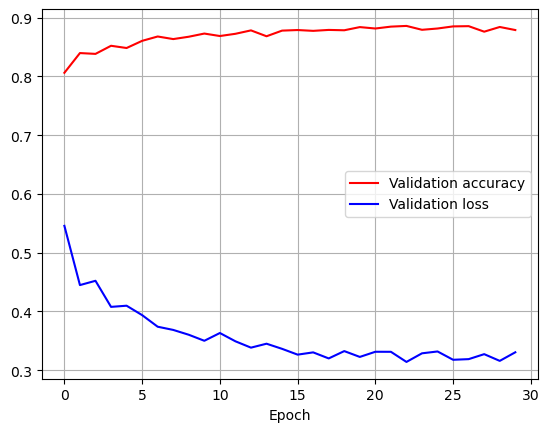

In [26]:
plt.plot(np.arange(30), test_accuracy, 'r-', label='Validation accuracy')
plt.plot(np.arange(30), test_loss, 'b-', label='Validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Performance on the test set

In [27]:
def get_test_performance(dataloader, model):
    test_accuracy = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).type(torch.float32).sum().item()
    return correct / len(dataloader.dataset)

In [28]:
get_test_performance(test_loader, classif_model)

0.8774

## Building a Regression MLP Using the Sequential API

For this example we use the California Housing dataset. After creating a training, validation, and test set, we must normalize the data and organize them into dataloaders.

In [29]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

In [30]:
x_train.shape, x_valid.shape, x_test.shape

((11610, 8), (3870, 8), (5160, 8))

In [31]:
x_test[0]

array([ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,  1.02228412e+00,
        1.39200000e+03,  3.87743733e+00,  3.60600000e+01, -1.19010000e+02])

In [32]:
means, std_devs = x_train.mean(axis=0), x_train.std(axis=0)
means.shape, std_devs.shape

((8,), (8,))

In [33]:
x_train = ((x_train - means) / std_devs).astype(np.float32)
x_valid = ((x_valid - means) / std_devs).astype(np.float32)
x_test = ((x_test - means) / std_devs).astype(np.float32)

In [34]:
x_test.dtype

dtype('float32')

In [49]:
x_tensor_train = torch.FloatTensor(x_train)
y_tensor_train = torch.FloatTensor(y_train).unsqueeze(-1)
x_tensor_valid = torch.FloatTensor(x_valid)
y_tensor_valid = torch.FloatTensor(y_valid).unsqueeze(-1)
x_tensor_test = torch.FloatTensor(x_test)
y_tensor_test = torch.FloatTensor(y_test).unsqueeze(-1)

In [35]:
train_dset = TensorDataset(x_tensor_train, y_tensor_train)
valid_dset = TensorDataset(x_tensor_valid, y_tensor_valid)
test_dset = TensorDataset(x_tensor_test, y_tensor_test)

In [36]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [37]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=8, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=1))
    
    def forward(self, x):
        return self.sequential_model(x)

### Weight initialization

In [38]:
regression_model = RegressionModel()
regression_model.apply(init_weights)

RegressionModel(
  (sequential_model): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [39]:
regression_model = regression_model.to(device)

In [40]:
def train_regression(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            print(f'Train Loss: {batch_loss.item():>.5}. Batch: [{batch}/{num_batches}]')

In [41]:
def eval_regression(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [42]:
loss_fn = nn.MSELoss()
regression_optim = optim.Adam(regression_model.parameters(), lr=1e-3, eps=1e-7)

In [43]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----\n')
    train_regression(train_loader, regression_model, loss_fn, regression_optim)
    eval_regression(valid_loader, regression_model, loss_fn)


 ----- Epoch 1 -----

Train Loss: 5.6102. Batch: [0/363]
Train Loss: 0.52433. Batch: [100/363]
Train Loss: 0.66967. Batch: [200/363]
Train Loss: 0.33699. Batch: [300/363]
Validation Loss: 0.72447

 ----- Epoch 2 -----

Train Loss: 0.5272. Batch: [0/363]
Train Loss: 0.22577. Batch: [100/363]
Train Loss: 0.23623. Batch: [200/363]
Train Loss: 0.3455. Batch: [300/363]
Validation Loss: 3.0015

 ----- Epoch 3 -----

Train Loss: 0.50808. Batch: [0/363]
Train Loss: 0.91866. Batch: [100/363]
Train Loss: 0.68902. Batch: [200/363]
Train Loss: 0.16467. Batch: [300/363]
Validation Loss: 1.1817

 ----- Epoch 4 -----

Train Loss: 0.29163. Batch: [0/363]
Train Loss: 0.23263. Batch: [100/363]
Train Loss: 0.3162. Batch: [200/363]
Train Loss: 0.42507. Batch: [300/363]
Validation Loss: 1.0185

 ----- Epoch 5 -----

Train Loss: 0.16569. Batch: [0/363]
Train Loss: 0.12829. Batch: [100/363]
Train Loss: 0.53072. Batch: [200/363]
Train Loss: 0.28417. Batch: [300/363]
Validation Loss: 0.91683

 ----- Epoch 6 -

## Building Complex Models Using the Functional API

In [44]:
class WideAndDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=8, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=38, out_features=1)
    
    def forward(self, x):
        z = self.relu(self.hidden_layer1(x))
        z = self.relu(self.hidden_layer2(z))
        w = torch.cat((x, z), dim=-1)
        return self.output_layer(w)

In [45]:
widedeep = WideAndDeep()
widedeep.apply(init_weights)
widedeep = widedeep.to(device)

Note that we need to create another optimizer, as the existing one has been trained on a different architecture.

In [46]:
wnd_optim = optim.Adam(widedeep.parameters(), lr=1e-3, eps=1e-7)

In [47]:
for epoch in range(20):
    train_regression(train_loader, widedeep, loss_fn, wnd_optim)
    eval_regression(valid_loader, widedeep, loss_fn)

Train Loss: 4.9973. Batch: [0/363]
Train Loss: 0.79704. Batch: [100/363]
Train Loss: 0.84926. Batch: [200/363]
Train Loss: 0.51205. Batch: [300/363]
Validation Loss: 0.89775
Train Loss: 0.35408. Batch: [0/363]
Train Loss: 0.21947. Batch: [100/363]
Train Loss: 0.5549. Batch: [200/363]
Train Loss: 0.44046. Batch: [300/363]
Validation Loss: 0.42174
Train Loss: 0.39329. Batch: [0/363]
Train Loss: 0.26698. Batch: [100/363]
Train Loss: 0.30138. Batch: [200/363]
Train Loss: 0.58435. Batch: [300/363]
Validation Loss: 0.4753
Train Loss: 0.31146. Batch: [0/363]
Train Loss: 0.59773. Batch: [100/363]
Train Loss: 0.567. Batch: [200/363]
Train Loss: 0.23096. Batch: [300/363]
Validation Loss: 0.41072
Train Loss: 0.77299. Batch: [0/363]
Train Loss: 0.21619. Batch: [100/363]
Train Loss: 0.49299. Batch: [200/363]
Train Loss: 0.74151. Batch: [300/363]
Validation Loss: 1.6573
Train Loss: 0.39667. Batch: [0/363]
Train Loss: 0.28282. Batch: [100/363]
Train Loss: 0.44575. Batch: [200/363]
Train Loss: 0.17881

### Sending inputs through two different paths

The next example HOML3 sends features 0 to 4 to the wide path and features 2 to 7 through the deep path as shown below ![wide_deep](img/mls3_1015.png). To make this work we need to:

1. Modify the Dataset so that it returns two inputs and one target.
2. Modify the model so that it has two inputs.

In this case, since there is only one output, the loss is unchanged. The source code for TensorDataset can be found [here](https://github.com/pytorch/pytorch/blob/03de15806e5d27ee4ef6d82dbcc66dac78f6e3bf/torch/utils/data/dataset.py#L193).

We just need to redefine `__getitem__()` and we don't need to touch `__init__()`. Our modified implementation returns a tuple containing a tuple of inputs and the output tensor.

In [107]:
class WideAndDeepDataset(TensorDataset):
    def __getitem__(self, index):
        tensor_x, tensor_y = self.tensors
        x_wide, x_deep = tensor_x[:, :5], tensor_x[:, 2:]
        return (x_wide[index], x_deep[index], tensor_y[index])

In [108]:
wnd_train_dset = WideAndDeepDataset(x_tensor_train, y_tensor_train)
wnd_valid_dset = WideAndDeepDataset(x_tensor_valid, y_tensor_valid)
wnd_test_dset = WideAndDeepDataset(x_tensor_test, y_tensor_test)

In [109]:
wnd_train_loader = DataLoader(wnd_train_dset, batch_size, shuffle=True)
wnd_valid_loader = DataLoader(wnd_valid_dset, batch_size, shuffle=False)
wnd_test_loader = DataLoader(wnd_test_dset, batch_size, shuffle=False)

In [110]:
class WideAndDeepTwoInputs(nn.Module):
    # x_wide contains 5 features. x_deep contains 6
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=6, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=35, out_features=1)
    
    def forward(self, x_wide, x_deep):
        x_deep = self.relu(self.hidden_layer1(x_deep))
        x_deep = self.relu(self.hidden_layer2(x_deep))
        w = torch.cat((x_wide, x_deep), dim=-1)
        return self.output_layer(w)

In [111]:
model_two_inputs = WideAndDeepTwoInputs()
model_two_inputs.apply(init_weights)
model_two_inputs = model_two_inputs.to(device)

In [112]:
def train_two_inputs(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x_wide, x_deep, y) in enumerate(dataloader):
        x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
        preds = model(x_wide, x_deep)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            print(f'Train Loss: {batch_loss.item():>.5}. Batch: [{batch}/{num_batches}]')

In [113]:
def eval_two_inputs(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x_wide, x_deep, y in dataloader:
            x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
            preds = model(x_wide, x_deep)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [114]:
wnd_optim_two_inputs = optim.Adam(widedeep.parameters(), lr=1e-3, eps=1e-7)

In [106]:
for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----\n")
    train_two_inputs(wnd_train_loader, model_two_inputs, loss_fn, wnd_optim_two_inputs)
    eval_two_inputs(wnd_valid_loader, model_two_inputs, loss_fn)


----- Epoch: 1 -----

Train Loss: 6.5514. Batch: [0/363]
Train Loss: 6.4527. Batch: [100/363]
Train Loss: 5.63. Batch: [200/363]
Train Loss: 12.161. Batch: [300/363]
Validation Loss: 9.1545

----- Epoch: 2 -----

Train Loss: 5.8491. Batch: [0/363]
Train Loss: 7.0123. Batch: [100/363]
Train Loss: 11.389. Batch: [200/363]
Train Loss: 9.6632. Batch: [300/363]
Validation Loss: 9.1545

----- Epoch: 3 -----

Train Loss: 5.8329. Batch: [0/363]
Train Loss: 6.0983. Batch: [100/363]
Train Loss: 11.146. Batch: [200/363]
Train Loss: 6.7976. Batch: [300/363]
Validation Loss: 9.1545

----- Epoch: 4 -----

Train Loss: 10.301. Batch: [0/363]
Train Loss: 5.6044. Batch: [100/363]
Train Loss: 5.8515. Batch: [200/363]
Train Loss: 5.2471. Batch: [300/363]
Validation Loss: 9.1545

----- Epoch: 5 -----

Train Loss: 6.0951. Batch: [0/363]
Train Loss: 6.3694. Batch: [100/363]
Train Loss: 4.5136. Batch: [200/363]
Train Loss: 11.166. Batch: [300/363]
Validation Loss: 9.1545

----- Epoch: 6 -----

Train Loss: 6.